# XGBoost: Extreme Gradient Boosting (Technical Notes)

## 1. What is XGBoost?

**XGBoost (Extreme Gradient Boosting)** is an optimized implementation of **gradient boosted decision trees (GBDT)** designed for:
- high performance (speed & scalability),
- strong regularization,
- robustness to overfitting,
- efficient handling of sparse and large-scale data.

Formally, XGBoost builds an **additive model** of decision trees by minimizing a regularized empirical risk using **second-order (Newton) optimization**.


## 2. Model Definition

Given a dataset  
$\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$, where $x_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$.

XGBoost models the prediction as an additive ensemble of $K$ regression trees:
$\hat{y}_i = \sum_{k=1}^K f_k(x_i)$, with $f_k \in \mathcal{F}$.

Each tree $f$ maps an input to a **leaf weight**:
$f(x) = w_{q(x)}$, where $q(x): \mathbb{R}^d \rightarrow \{1,\dots,T\}$ assigns $x$ to a leaf index.

- $q(x)$: tree structure (split rules)
- $T$: number of leaves in the tree
- $w_j$: prediction score associated with leaf $j$

Equivalently, each tree is a **piecewise-constant function** over the input space, and the full XGBoost model is a linear combination of such functions.


## 3. Objective Function

XGBoost minimizes a **regularized objective**:  
$\mathcal{L} = \sum_{i=1}^n \ell(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$

### 3.1 Loss Term

- Regression: squared error  
$\ell(y, \hat{y}) = (y - \hat{y})^2$

- Classification: logistic loss  
$\ell(y, \hat{y}) = -\left[y \log \sigma(\hat{y}) + (1-y)\log(1-\sigma(\hat{y}))\right]$

where $\sigma(z) = (1+e^{-z})^{-1}$.

### 3.2 Regularization Term

$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$

- $\gamma$: penalty for adding a leaf (controls tree complexity)  
- $\lambda$: L2 regularization on leaf weights  


## 4. Additive Training (Boosting)

Trees are added **one at a time**:  
$\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$

At iteration $t$, we minimize:  
$\mathcal{L}^{(t)} = \sum_i \ell\!\left(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t)$

This corresponds to **stagewise additive modeling** in function space.

## 5. Second-Order Taylor Expansion (Key Idea)

XGBoost uses a second-order (Newton) approximation of the loss.

Define first- and second-order derivatives with respect to the current prediction:  
$g_i = \partial \ell(y_i, \hat{y}_i) / \partial \hat{y}_i$  
$h_i = \partial^2 \ell(y_i, \hat{y}_i) / \partial \hat{y}_i^2$

Second-order expansion around $\hat{y}_i^{(t-1)}$:  
$\ell(y_i, \hat{y}_i^{(t-1)} + f(x_i)) \approx \ell(y_i, \hat{y}_i^{(t-1)}) + g_i f(x_i) + \frac{1}{2} h_i f(x_i)^2$

Dropping constants independent of $f$:  
$\tilde{\mathcal{L}}^{(t)} = \sum_i \left[g_i f(x_i) + \frac{1}{2} h_i f(x_i)^2\right] + \Omega(f)$

## 6. Optimal Leaf Weights

For a fixed tree structure, let $I_j$ be the set of samples assigned to leaf $j$.

Define aggregated gradients and Hessians:  
$G_j = \sum_{i \in I_j} g_i$  
$H_j = \sum_{i \in I_j} h_i$

The optimal leaf weight is:  
$w_j^* = -\frac{G_j}{H_j + \lambda}$

The minimized objective contribution of that leaf is:  
$\mathcal{L}_j^* = -\frac{1}{2}\frac{G_j^2}{H_j + \lambda}$

## 7. Split Criterion (Gain)

When splitting a node into left (L) and right (R) child nodes:

$\text{Gain} = \frac{1}{2}\left(
\frac{G_L^2}{H_L + \lambda}
+ \frac{G_R^2}{H_R + \lambda}
- \frac{(G_L + G_R)^2}{H_L + H_R + \lambda}
\right) - \gamma$

A split is accepted if Gain > 0.

## 9. Subsampling and Column Sampling

To reduce variance and overfitting, XGBoost applies random subsampling:

- Row subsampling: subsample  
- Column subsampling: colsample_bytree, colsample_bylevel, colsample_bynode

These mechanisms inject randomness similarly to Random Forests.

## 10. Handling Missing Values

XGBoost learns a default split direction for missing values at each node by selecting the direction that minimizes the loss.

No explicit imputation is required.

## 11. Comparison with Other Tree Ensembles

| Method | Key Idea |
|------|---------|
| Bagging / Random Forest | Variance reduction via averaging |
| Gradient Boosting | Sequential bias reduction |
| XGBoost | Boosting with Newton updates and regularization |

# Python code implementation

### Set GPU

In [3]:
import os
# Force XGBoost to see only GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES =", os.environ["CUDA_VISIBLE_DEVICES"])
# import subprocess

# try:
#     out = subprocess.check_output(["nvidia-smi"], stderr=subprocess.STDOUT)
#     print("nvidia-smi output:\n")
#     print(out.decode())
# except Exception as e:
#     print("nvidia-smi not available:", e)


CUDA_VISIBLE_DEVICES = 0


### Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

### Generates data

In [7]:
X, y = make_regression(
    n_samples=100_000,
    n_features=50,
    noise=0.1,
    random_state=42
)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (80000, 50)
Testing data shape: (20000, 50)


### Set model

In [25]:
model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,

    # ---- GPU-specific ----
    tree_method="hist",     # REQUIRED for GPU
    predictor="gpu_predictor",  # GPU inference
    device="cuda:0",        # MUST be a string, NOT 0

    # ---- regularization ----
    reg_lambda=1.0,
    reg_alpha=0.0,

    objective="reg:squarederror",
    verbosity=2                 # IMPORTANT: show GPU logs
)

### XGBoost Hyperparameters (GPU setup) — Concise Summary

#### Model size & capacity
- `n_estimators`  
  Number of boosting rounds (trees). Controls total model capacity. Larger → lower bias, higher variance.

- `max_depth`  
  Maximum depth of each tree. Controls interaction order and expressiveness.

- `learning_rate` (`η`)  
  Shrinkage factor in  
  $\hat y^{(t)} = \hat y^{(t-1)} + \eta f_t(x)$.  
  Smaller values improve generalization but require more trees.

---

#### Stochastic regularization
- `subsample`  
  Fraction of training rows used per tree. Reduces variance via randomness.

- `colsample_bytree`  
  Fraction of features used per tree. Stabilizes splits and reduces overfitting.

---

#### GPU execution (critical)
- `tree_method="gpu_hist"`  
  Enables GPU training using histogram-based split finding.

- `predictor="gpu_predictor"`  
  Forces inference to run on GPU (prevents CPU fallback).

- `gpu_id`  
  GPU index relative to `CUDA_VISIBLE_DEVICES`.

---

#### Explicit regularization
- `reg_lambda` (`λ`)  
  L2 regularization on leaf weights. Appears in  
  $w_j^* = -G_j/(H_j+\lambda)$.  
  Most important stabilizer.

- `reg_alpha` (`α`)  
  L1 regularization on leaf weights. Encourages sparsity.

---

#### Objective / loss
- `objective="reg:squarederror"`  
  Uses squared loss  
  $\ell(y,\hat y)=(y-\hat y)^2$  
  with gradient $g=\hat y-y$ and Hessian $h=1$.

---

#### Logging & diagnostics
- `verbosity`  
  Controls training output. Use `2` to confirm GPU usage.

---

#### Important related parameters (not shown above)
- `min_split_loss` (`γ`)  
  Minimum gain required to split a node. Larger → simpler trees.

- `min_child_weight`  
  Minimum Hessian sum per leaf. Prevents unstable small leaves.

- `max_bin`  
  Number of histogram bins (GPU-relevant). Higher → more accurate, slower.

---

#### Core parameters to remember
1. `tree_method="gpu_hist"` — GPU training
2. `learning_rate` — bias–variance tradeoff
3. `n_estimators` — number of trees
4. `max_depth` — tree complexity
5. `reg_lambda` — numerical stability


In [26]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[18:18:56] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (80000, 50, 4000000).
[18:18:56] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (20000, 50, 1000000).
[18:18:57] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
[18:18:57] INFO: /workspace/src/common/cuda_dr_utils.cc:179: Driver version: `580.95`
[18:18:57] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
[0]	validation_0-rmse:217.09603
[1]	validation_0-rmse:212.26475
[2]	validation_0-rmse:207.86854
[3]	validation_0-rmse:202.87006
[4]	validation_0-rmse:196.66352
[5]	validation_0-rmse:191.38428
[6]	validation_0-rmse:186.07332
[7]	validation_0-rmse:181.79314
[8]	validation_0-rmse:176.53379
[9]	validation_0-rmse:171.57106
[10]	validation_0-rmse:167.35457
[11]	validation_0-rmse:162.83326
[12]	validation_0-rmse:159.11575
[13]	validation_0-rmse:155.06769
[14]	validation_0-rmse:151.57137
[15]	validation_0

/scratch/scratch-lxu/venv/cmbagent_env/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[32]	validation_0-rmse:102.91778
[33]	validation_0-rmse:100.80839
[34]	validation_0-rmse:98.98116
[35]	validation_0-rmse:97.11069
[36]	validation_0-rmse:95.43382
[37]	validation_0-rmse:93.61506
[38]	validation_0-rmse:91.79066
[39]	validation_0-rmse:90.06900
[40]	validation_0-rmse:88.67750
[41]	validation_0-rmse:87.01908
[42]	validation_0-rmse:85.42385
[43]	validation_0-rmse:83.91900
[44]	validation_0-rmse:82.41633
[45]	validation_0-rmse:81.02055
[46]	validation_0-rmse:79.67998
[47]	validation_0-rmse:78.27588
[48]	validation_0-rmse:76.94454
[49]	validation_0-rmse:75.64938
[50]	validation_0-rmse:74.40139
[51]	validation_0-rmse:73.17606
[52]	validation_0-rmse:72.00292
[53]	validation_0-rmse:70.84086
[54]	validation_0-rmse:69.70717
[55]	validation_0-rmse:68.61019
[56]	validation_0-rmse:67.53601
[57]	validation_0-rmse:66.52573
[58]	validation_0-rmse:65.50236
[59]	validation_0-rmse:64.54852
[60]	validation_0-rmse:63.58847
[61]	validation_0-rmse:62.68580
[62]	validation_0-rmse:61.78839
[63]	v

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda:0'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [27]:
# confirm config
booster = model.get_booster()
print("\n--- booster config ---\n")
print(booster.save_config())



--- booster config ---

{"learner":{"generic_param":{"device":"cuda:0","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"500"},"gbtree_train_param":{"process_type":"default","tree_method":"hist","updater":"grow_gpu_hist","updater_seq":"grow_gpu_hist"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"0.800000012","eta":"0.0500000007","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.0500000007","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"8","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch

#### Model inference

In [32]:
# --- After model.fit(...) ---
import time
import subprocess
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1) Inspect evaluation history (assumes eval_set was provided)
results = model.evals_result()
print("\n=== evals_result keys ===", list(results.keys()))

ds0 = next(iter(results.keys()))
metric0 = next(iter(results[ds0].keys()))
vals = results[ds0][metric0]

print(f"Metric tracked: {ds0}/{metric0}")
print("Last 5 values:", vals[-5:])


=== evals_result keys === ['validation_0']
Metric tracked: validation_0/rmse
Last 5 values: [20.703864408734013, 20.703604916143004, 20.70339227945601, 20.702820853208465, 20.70359922759148]


In [33]:
# 2) Confirm training configuration (ground truth)
booster = model.get_booster()
print("\n=== Booster config (search for 'device' / 'tree_method') ===\n")
cfg = booster.save_config()
print(cfg)


=== Booster config (search for 'device' / 'tree_method') ===

{"learner":{"generic_param":{"device":"cuda:0","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"500"},"gbtree_train_param":{"process_type":"default","tree_method":"hist","updater":"grow_gpu_hist","updater_seq":"grow_gpu_hist"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"0.800000012","eta":"0.0500000007","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.0500000007","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"8","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"

In [34]:
# 3) GPU sanity check (assumes nvidia-smi exists)
smi = subprocess.check_output(
    ["nvidia-smi",
     "--query-gpu=index,name,memory.total,memory.used,utilization.gpu",
     "--format=csv,noheader"]
)
print("\n=== nvidia-smi (post-training) ===")
print(smi.decode())


=== nvidia-smi (post-training) ===
0, NVIDIA RTX PRO 6000 Blackwell Workstation Edition, 97887 MiB, 7246 MiB, 0 %
1, NVIDIA RTX PRO 6000 Blackwell Workstation Edition, 97887 MiB, 11853 MiB, 99 %



In [35]:
# 4) Evaluate on test set
t0 = time.time()
y_pred = model.predict(X_test)
dt = time.time() - t0

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("\n=== Test metrics ===")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R^2 : {r2:.6f}")
print(f"Predict time on test set: {dt:.4f} s  (n={len(y_test)})")


=== Test metrics ===
RMSE: 20.703599
MAE : 15.308061
R^2 : 0.991474
Predict time on test set: 0.0392 s  (n=20000)


In [36]:
# 5) Feature importance
importance_gain = booster.get_score(importance_type="gain")
importance_weight = booster.get_score(importance_type="weight")

print("\n=== Top features by GAIN ===")
for k in sorted(importance_gain, key=importance_gain.get, reverse=True)[:10]:
    print(f"{k}: {importance_gain[k]:.6g}")

print("\n=== Top features by WEIGHT ===")
for k in sorted(importance_weight, key=importance_weight.get, reverse=True)[:10]:
    print(f"{k}: {importance_weight[k]}")


=== Top features by GAIN ===
f29: 1.12565e+06
f35: 1.08204e+06
f48: 1.02667e+06
f19: 889668
f4: 766012
f25: 570808
f18: 567434
f11: 246978
f17: 169332
f21: 27755.3

=== Top features by WEIGHT ===
f4: 5986.0
f35: 5491.0
f48: 5203.0
f19: 5176.0
f29: 5086.0
f18: 4913.0
f11: 4765.0
f25: 4662.0
f0: 4447.0
f17: 4227.0


In [37]:
# 6) Save & load the model
model_path = "xgb_gpu_model.json"
model.save_model(model_path)
print(f"\nSaved model to: {model_path}")

loaded = type(model)()
loaded.load_model(model_path)

y_pred_loaded = loaded.predict(X_test)
max_abs_diff = float(np.max(np.abs(y_pred - y_pred_loaded)))
print(f"Max |pred - pred_loaded| = {max_abs_diff:.3e}")


Saved model to: xgb_gpu_model.json
Max |pred - pred_loaded| = 3.052e-04


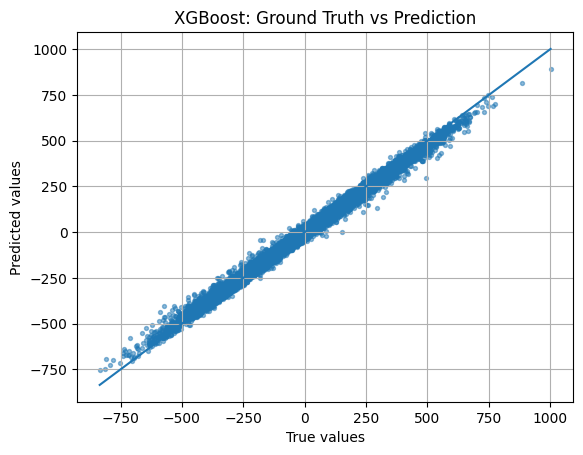

In [39]:
# 7) Ground truth vs prediction plot
plt.figure()
plt.scatter(y_test, y_pred, s=8, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("XGBoost: Ground Truth vs Prediction")
plt.grid(True)
plt.show()


In [45]:
import xgboost as xgb
from xgboost import XGBRegressor

early_stop = xgb.callback.EarlyStopping(
    rounds=100,
    metric_name="rmse",
    data_name="validation_0",
    save_best=True,
)

model_es = XGBRegressor(
    n_estimators=5000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="cuda:0",
    objective="reg:squarederror",
    eval_metric="rmse",
    callbacks=[early_stop],
    verbosity=1,
)

In [46]:
model_es.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50,
)

print("Best iteration:", model_es.best_iteration)
print("Best score:", model_es.best_score)


[0]	validation_0-rmse:219.92979
[50]	validation_0-rmse:107.95967
[100]	validation_0-rmse:64.14724
[150]	validation_0-rmse:43.08580
[200]	validation_0-rmse:32.12659
[250]	validation_0-rmse:26.32571
[300]	validation_0-rmse:23.20076
[350]	validation_0-rmse:21.47442
[400]	validation_0-rmse:20.52919
[450]	validation_0-rmse:20.01231
[500]	validation_0-rmse:19.70582
[550]	validation_0-rmse:19.53990
[600]	validation_0-rmse:19.42211
[650]	validation_0-rmse:19.35983
[700]	validation_0-rmse:19.29681
[750]	validation_0-rmse:19.25576
[800]	validation_0-rmse:19.21351
[850]	validation_0-rmse:19.17970
[900]	validation_0-rmse:19.15026
[950]	validation_0-rmse:19.12404
[1000]	validation_0-rmse:19.10336
[1050]	validation_0-rmse:19.08737
[1100]	validation_0-rmse:19.08278
[1150]	validation_0-rmse:19.06913
[1200]	validation_0-rmse:19.06145
[1250]	validation_0-rmse:19.04855
[1300]	validation_0-rmse:19.03820
[1350]	validation_0-rmse:19.02733
[1400]	validation_0-rmse:19.02081
[1450]	validation_0-rmse:19.01008
[

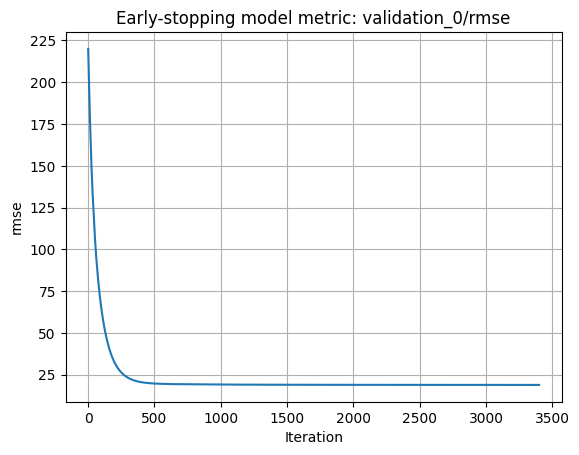

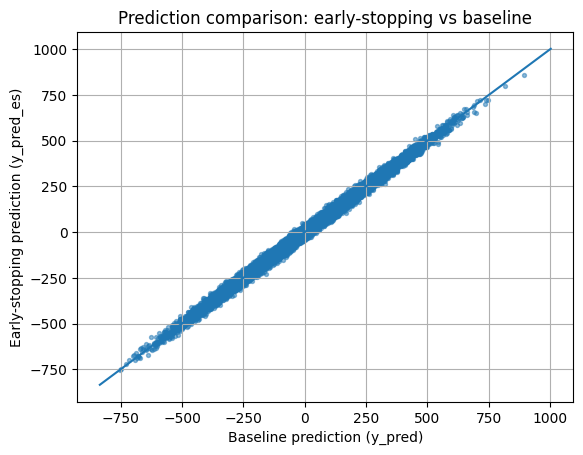

RMSE baseline: 20.703599180776425
RMSE early-stopping: 18.896636901967042
RMSE improvement (baseline - early): 1.806962278809383


In [48]:
# --- 1) Plot diagnostic metric (from early-stopping model) ---
res_es = model_es.evals_result()

ds0 = next(iter(res_es.keys()))                # typically "validation_0"
metric0 = next(iter(res_es[ds0].keys()))       # e.g. "rmse"
metric_vals = np.asarray(res_es[ds0][metric0], dtype=float)

plt.figure()
plt.plot(np.arange(1, len(metric_vals) + 1), metric_vals)
plt.xlabel("Iteration")
plt.ylabel(metric0)
plt.title(f"Early-stopping model metric: {ds0}/{metric0}")
plt.grid(True)
plt.show()

# --- 2) Predictions from early-stopping model ---
y_pred_es = model_es.predict(X_test)

# --- 4) Direct comparison: early-stopping pred vs baseline pred ---
plt.figure()
plt.scatter(y_pred, y_pred_es, s=8, alpha=0.5)
plt.plot([xmin, xmax], [xmin, xmax])
plt.xlabel("Baseline prediction (y_pred)")
plt.ylabel("Early-stopping prediction (y_pred_es)")
plt.title("Prediction comparison: early-stopping vs baseline")
plt.grid(True)
plt.show()

# --- 5) Quantify improvement (RMSE difference) ---
rmse_base = float(np.sqrt(np.mean((y_test - y_pred)**2)))
rmse_es   = float(np.sqrt(np.mean((y_test - y_pred_es)**2)))
print("RMSE baseline:", rmse_base)
print("RMSE early-stopping:", rmse_es)
print("RMSE improvement (baseline - early):", rmse_base - rmse_es)
